In [ ]:
""" What does this code does?
This notebook generates 'lig', 'inter', and 'prot' files
from TSV files retrieved from the Binding DB dataset. Those
files are properly formatted to be used at RINDTI model
https://rindti.readthedocs.io/en/master/index.html

The files (TSV, TXT, or images) will contain information 
about:
    Class balance: This code will downsample the dataset to easily-tune 
    a max radio of 1:3. Minimum samples per class is also easily-tune parameter.
    results/active-inactives_info.txt file generated will provide the class balance per target.
    results/class_balance.txt file will contain global information of dataset balance.
    This code will balance each target active-inactives radio, NOT just whole set.

    Molecular descriptors: This code will generate a image of molecular descriptor of 
    dataset distribution of all dataset after lipinski rules filtering.
    Also complete dataset information can be generated from this code as those molecular
    descriptors are generated from rdkit in this notebook.
    
    pbd2fasta: This code also contain codes that are usuful to get fasta sequences from pdbs
    and place that information in new cells in dataframe. This code could be reused in 
    future as its own as it based on: https://github.com/kalininalab/useful_scripts/tree/main/Ilya

    pdb-cleaning: This code also contains a cell code that is useful to clean pdbs from other
    non-protein molecules, as ligands, water or metals and get only protein molecules.

    pdb folder: This code also generated a folder with pdb structures and renames it as pdb id.pdb,
    same name that would be used in prot.tsv id.

    Active Threshold: This code also create the active-inactive classification based
    on a cutoff of 10 mM. Whereas less than 10 mM indicates positive activity.

    Filter by EC number: In case to be interest in specific class of enzymatic activity,
    it could be filter by EC number. However, this highly depends on pdb files, since
    that number is retrieved from the information contained in that pdb.ent file. If non-existent
    will not be parse to dataframe.

    Formatted dataset: The dataset is properly formatted to be used at RINDTI model
    https://rindti.readthedocs.io/en/master/index.html 
"""

In [4]:
## general libraries of the notebook
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## define working directory
pwd = os.getcwd()

## possible datasets manually retrived from:
## https://www.bindingdb.org/rwd/bind/chemsearch/marvin/Download.jsp
#db = 'BindingDB_ChEMBL.tsv'
#db = 'BindingDB_PubChem.tsv'
#db = 'BindingDB_BindingDB_Articles.tsv'
#db = 'BindingDB_Covid-19.tsv'
db = 'BindingDB_All.tsv'

# parse binding data into dataset [only columns that really matters]
dataset = pd.read_csv(str(pwd) + "/" + str(db), sep="\t",
                      usecols=['BindingDB Reactant_set_id', 'Ligand SMILES', 'Target Name', 'IC50 (nM)', 'PDB ID(s) for Ligand-Target Complex'])

# create folder for results that would be generated
new_folder = './results_' + str(db.replace('.tsv', ''))

# check whether directory already exists
if not os.path.exists(new_folder):
    os.mkdir(new_folder)  

/tmp/ipykernel_22321/3427304583.py:20: DtypeWarning: Columns (9,28) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(str(pwd) + "/" + str(db), sep="\t",


In [ ]:
""" First step |
This part of the notebook filters the dataset by only considering data that has IC50 values
and targets that have PDB structures. 
"""

In [2]:
dataset.shape

(2702441, 5)

In [3]:
""" Data processing I | Managing columns names and formatting data types
"""

# rename columns
dataset.columns = ['Drug_ID', 'Drug', 'Target_ID', 'IC50', 'PDB_ID']
# add prefix to drugs
dataset['Drug_ID'] = 'drg_' + dataset['Drug_ID'].astype(str)
# save ic50 into floats and remove str characters
dataset["IC50"] = dataset["IC50"].str.replace('>', '')
dataset["IC50"] = dataset["IC50"].str.replace('<', '')
# Convert the column to numeric values, setting 'coerce' to convert non-convertible elements to NaN
dataset['IC50'] = pd.to_numeric(dataset['IC50'], errors='coerce')
# Drop rows with NaN values in the 'IC50' column
dataset.dropna(subset=['IC50'], inplace=True)
# convert data to float
dataset = dataset.astype({"IC50": "float64"})

In [4]:
""" Data processing II | Creating class labels and computing logarithms
"""

# create label column in dataset
dataset["label"] = np.nan
# label as active or inactives ## active < 10mM
dataset.loc[dataset['IC50'] < 10000.0, 'label'] = 'active'
dataset.loc[dataset['IC50'] >= 10000.0, 'label'] = 'inactive'

# compute log of IC50 values
# Replace zero values with a small positive value
dataset['IC50'] = dataset['IC50'].replace(0, 1e-10)
# Convert 'IC50' column to logarithmic values
dataset['pIC50'] = np.log10(dataset['IC50'])
# Drop duplicates
dataset.drop_duplicates(subset=['Drug'], inplace=True)
dataset.drop_duplicates(subset=['Drug_ID'], inplace=True)
## reset index
dataset.reset_index(inplace=True)

In [5]:
dataset.shape

(851374, 8)

In [6]:
## keep data in dataset only if pdb is available
dataset = dataset[dataset['PDB_ID'].notna()]
# # Extract the first pdb ID from each element in the column
dataset['PDB_ID'] = dataset['PDB_ID'].str.split(',').str.get(0)

In [7]:
dataset.shape

(9556, 8)

In [8]:
""" CHECKPOINT | Initial information of dataset class balance
"""

# check for balance
print('Num of targets is ' +
      str(len(list(dataset['PDB_ID'].drop_duplicates()))))
print(' ')
print("the number of compounds is " + str(dataset.shape[0]))
print(' ')
print("Class blance is ")
dataset['label'].value_counts()

Num of targets is 9127
 
the number of compounds is 9556
 
Class blance is 


active      7090
inactive    2466
Name: label, dtype: int64

In [ ]:
""" Second step |
This code will add new columns with molecular descriptors values and will plot
the molecular descriptors destribution after dataset filtering by lipinski rules
"""

In [10]:
""" Molecular descriptors | This cell uses RDKIT to calculate molecular descriptors,
'Molecular formula', 'Molecular Weight', 'Number of Atoms', 'Number of Heavy Atoms', 
'Hydrogen bond donors', 'Hydrogen bond acceptors', 'Number of rotable bonds', 
'Polar surface area', 'LogP', 'aromatic rings'
"""

#libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import rdMolDescriptors
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import MolFromSmiles

## create a dataframe columns to place the information computed by RDKIT
df = pd.DataFrame(columns=['Molecular formula', 'Molecular Weight', 'Number of Atoms', 'Number of Heavy Atoms', 'Hydrogen bond donors (Lipinski)',
                  'Hydrogen bond acceptors (Lipinski)', 'Number of rotable bonds', 'Polar surface area', 'LogP', 'aromatic rings'])

# if error skip molecule, It'll be cleaned later
def calculate_descriptors(mol):
    if mol is None:
        return pd.Series({
            'formula': None,
            'weight': None,
            'num_atoms': None,
            'num_heavy_atoms': None,
            'num_hbd': None,
            'num_hba': None,
            'num_rot_bonds': None,
            'psa': None,
            'logp': None,
            'num_aromatic_rings': None
        })
    
    mol = Chem.MolFromSmiles(mol)
    if mol is None:
        return pd.Series({
            'formula': None,
            'weight': None,
            'num_atoms': None,
            'num_heavy_atoms': None,
            'num_hbd': None,
            'num_hba': None,
            'num_rot_bonds': None,
            'psa': None,
            'logp': None,
            'num_aromatic_rings': None
        })
    
    formula = rdMolDescriptors.CalcMolFormula(mol)
    weight = rdMolDescriptors.CalcExactMolWt(mol)
    num_atoms = rdMolDescriptors.CalcNumAtoms(mol)
    num_heavy_atoms = rdMolDescriptors.CalcNumHeavyAtoms(mol)
    num_hbd = rdMolDescriptors.CalcNumLipinskiHBD(mol)
    num_hba = rdMolDescriptors.CalcNumLipinskiHBA(mol)
    num_rot_bonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
    psa = rdMolDescriptors.CalcTPSA(mol)
    logp = Chem.Crippen.MolLogP(mol)
    num_aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)
    
    return pd.Series({
        'formula': formula,
        'weight': weight,
        'num_atoms': num_atoms,
        'num_heavy_atoms': num_heavy_atoms,
        'num_hbd': num_hbd,
        'num_hba': num_hba,
        'num_rot_bonds': num_rot_bonds,
        'psa': psa,
        'logp': logp,
        'num_aromatic_rings': num_aromatic_rings
    })
df = dataset.join(dataset['Drug'].apply(calculate_descriptors))

In [11]:
""" Cleaning | This cell removed not-found values in previous step

NOTE: output of this cell should be an empty df, since it just shows
howmany NaN exist AFTER cleaning, it could be modified by turning-off
the first two lines and check how many drugs you are losting by 
printing NaN values
"""

## remove not found values in previuos step
df.dropna(subset=['weight'], inplace=True)
df.reset_index(drop=True, inplace=True)

## check which values still have Nan values 
## if you want to check which will row will be eliminated
## run this three lines before the df.dropna of previous line
subset_df = df[df.isnull().any(axis=1)]
subset_df

,index,Drug_ID,Drug,Target_ID,IC50,PDB_ID,label,pIC50,formula,weight,num_atoms,num_heavy_atoms,num_hbd,num_hba,num_rot_bonds,psa,logp,num_aromatic_rings


In [12]:
""" Lipinski rules | This cell is used to filter and keep only the drugs 
that fulfill the statements of the Lipinski rules.
"""
# remove all row that contains MW | 500
df = df[df.weight < 500]
# remove all row that contains logP | 5
df = df[df.logp < 5]
# remove all row that contains logP | 5
df = df[df.logp > 0]
# remove all row that contains psa | 140 armgs
df = df[df.psa < 140]
# remove all row that contains hba | 10
df = df[df.num_hba < 10] 
# remove all row that contains hbd | 5
df = df[df.num_hbd < 5] 
# remove all row that contains rb | 10
df = df[df.num_rot_bonds < 10] 

In [ ]:
""" Balance of the dataset | This code will downsample the dataset to easily-tune 
a max radio of 1:4. Minimum samples per class is also easily-tune parameter.

This code will balance each target active-inactives radio, NOT just
whole set

UPDATE | unfortunatelly, even if this make sense to have all targets balanced
with at least certain number of examples in custum radio of active-inactives,
it downsample considerabely the number of examples. I'll keep it here, because
could be useful in the future this script. 
"""

# ## modules 
# from sklearn.utils import resample

# ## target dataframe from original dataframe
# targets = df['PDB_ID'].unique()

# ## hyperparameters
# min_examples = 1   # Minimum number of examples for each class
# max_ratio = 4  # Maximum ratio between the minority and majority classes

# balanced_data = []

# ## loop for each target
# for target in targets:
#     target_data = df[df['PDB_ID'] == target]
    
#     # Calculate the counts of each class
#     class_counts = target_data['label'].value_counts()
    
#     # only consider targets that has at least 'min_examples' examples in both classes
#     if len(class_counts) < 2 or any(class_counts < min_examples):
#         continue
    
#     # determine the minority and majority classes
#     minority_class = class_counts.idxmin()
#     majority_class = class_counts.idxmax()
    
#     # Separate the minority and majority classes
#     minority_data = target_data[target_data['label'] == minority_class]
#     majority_data = target_data[target_data['label'] == majority_class]
    
#     minority_count = minority_data.shape[0]
#     majority_count = majority_data.shape[0]
    
#     if minority_count >= min_examples and minority_count * max_ratio <= majority_count:
#         # Exclude targets with already balanced or minority-dominant class distributions
#         continue
    
#     if majority_count > minority_count * max_ratio:
#         # Undersample the majority class to achieve the desired ratio
#         desired_majority_count = min(minority_count * max_ratio, majority_count)  # Maximum ratio
        
#         undersampled_majority = resample(
#             majority_data,
#             replace=False,
#             n_samples=desired_majority_count,
#             random_state=42
#         )
        
#         balanced_target_data = pd.concat([minority_data, undersampled_majority])
#     else:
#         balanced_target_data = target_data
    
#     # Add the balanced data for this target to the list
#     balanced_data.append(balanced_target_data)
        
# # Combine the balanced data for all targets into a single DataFrame
# balanced_df = pd.concat(balanced_data)

# # rename dataset to original df
# df = balanced_df ## basically I reused code already named df """

In [13]:
""" CHECKPOINT | Initial information of dataset class balance
"""

# check for balance
print('Num of targets is ' +
      str(len(list(df['PDB_ID'].drop_duplicates()))))
print(' ')
print("the number of compounds is " + str(df.shape[0]))
print(' ')
print("Class blance is ")
df['label'].value_counts()

Num of targets is 5765
 
the number of compounds is 6022
 
Class blance is 


active      4307
inactive    1715
Name: label, dtype: int64

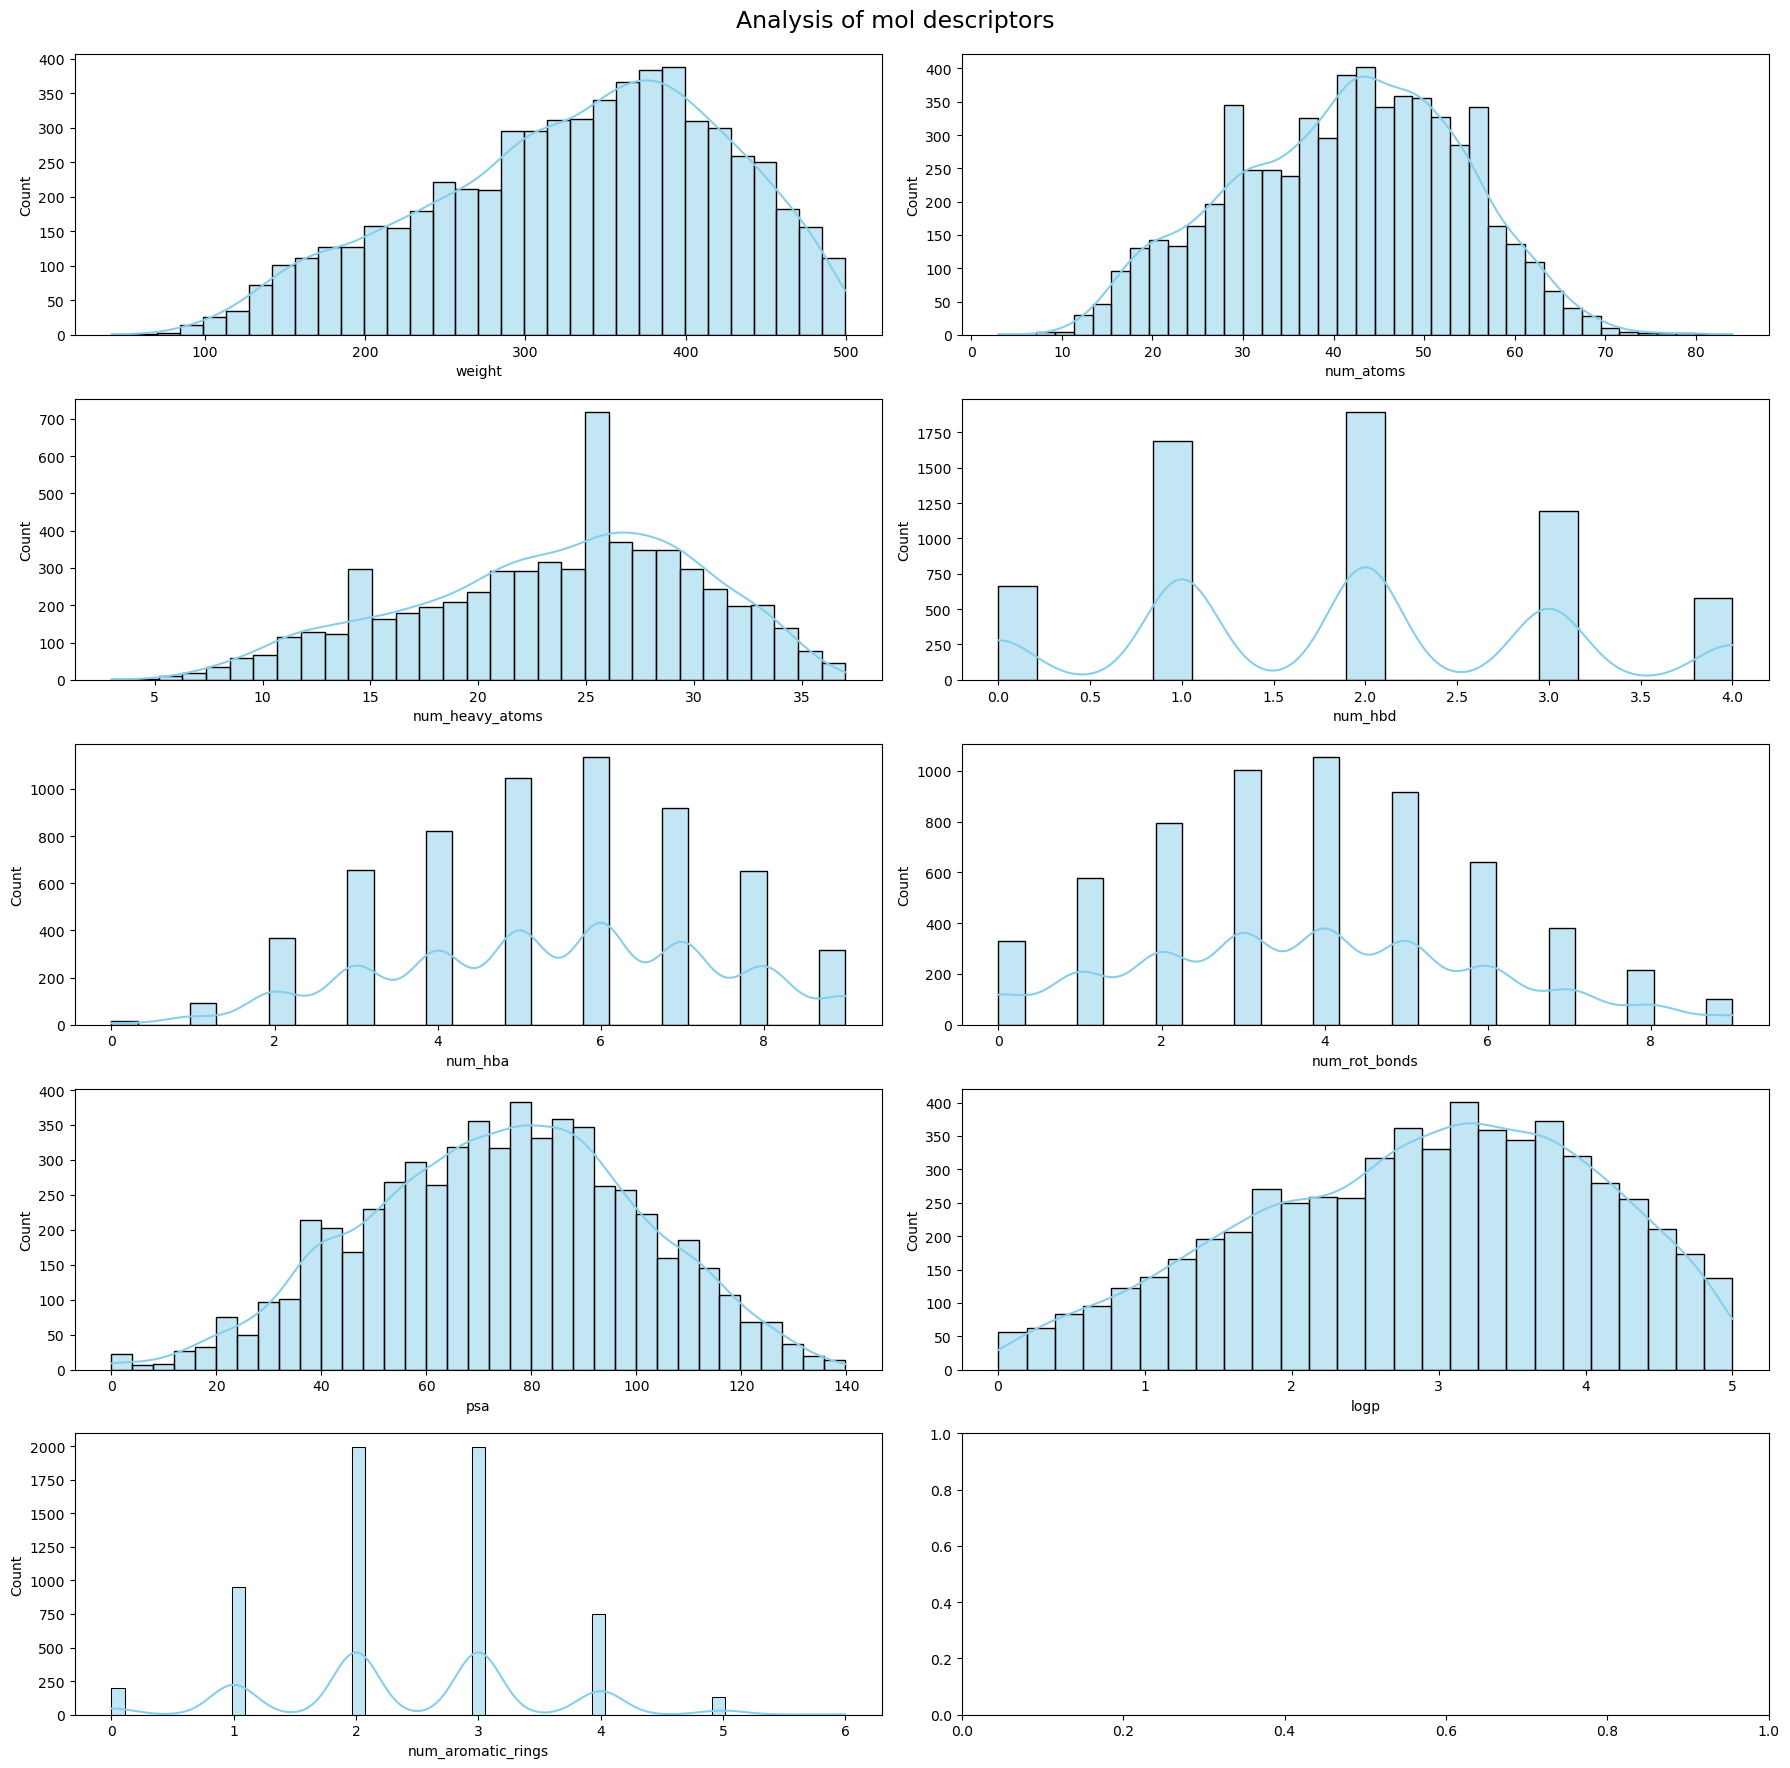

In [15]:
""" Molecular descriptors plot | This cell uses matplot lib to show and save the 
chemical distribution image of weight, num of atoms, num of heavy atoms, hb donors, ha acceptors,
num of rotable bonds, psa, logP
"""

#libraries
import matplotlib.pyplot as plt

# Define columns of df to plot
columns = [
    'weight',
    'num_atoms',
    'num_heavy_atoms',
    'num_hbd',
    'num_hba',
    'num_rot_bonds',
    'psa',
    'logp',
    'num_aromatic_rings']
# Calculate the number of rows and columns
n_rows = int(np.ceil(len(columns) / 2))
n_cols = 2

# Create a figure and subplots with larger size
fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 18))
# Make subplots
for i, column in enumerate(columns):
    axi = ax[i // n_cols][i % n_cols]
    fig.suptitle("Analysis of mol descriptors\n", fontsize=17)
    sns.histplot(data=df, x=column, ax=axi, kde=True, color='skyblue')
    plt.savefig(str(new_folder) + "/ChemDistributionof_" +str(db)+ '.jpg', format='jpg')

fig.tight_layout()

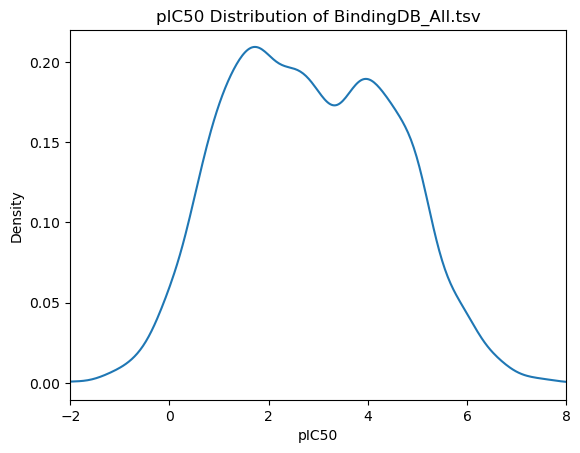

In [19]:
""" Y values distribution | this cell prints and save jpg images of the
distribution of pIC50 values of the dataset
"""

plt.figure()
df['pIC50'].plot(kind='kde')
plt.title('pIC50 Distribution of ' + str(db))
# Setting the x-axis range
plt.xlim(-2, 8)
plt.xlabel('pIC50')
plt.ylabel('Density')
    
# Save the figure
plt.savefig(str(new_folder) + "/pIC50_dist_" +str(db)+ '.jpg', format='jpg')

In [20]:
""" CHECKPOINT | dataset class balance after filter
"""
print('Num of targets is ' +
      str(len(list(df['PDB_ID'].drop_duplicates()))))
print(' ')
print("the number of compounds is " + str(df.shape[0]))
print(' ')
print("Class blance is ")
df['label'].value_counts()

Num of targets is 5765
 
the number of compounds is 6022
 
Class blance is 


active      4307
inactive    1715
Name: label, dtype: int64

In [21]:
""" Save active-inactive information | This save a txt files of the
class balance information of dataset per target
"""

# Get the unique target IDs
unique_targets = df['PDB_ID'].unique()

# Create a string to store all the information
output_string = ""

# Print the number of unique targets
num_targets = len(unique_targets)
output_string += 'Num of targets is ' + str(num_targets) + '\n\n'

# Print the information for each target
for target in unique_targets:
    output_string += "PDB_ID ID: " + str(target) + '\n'
    target_data = df[df['PDB_ID'] == target]
    
    # Print the number of compounds for the current target
    num_compounds = target_data.shape[0]
    output_string += "The number of compounds is " + str(num_compounds) + '\n'
    
    # Calculate and print the class balance for the current target
    class_balance = target_data['label'].value_counts()
    output_string += "Class balance is:\n"
    output_string += str(class_balance) + '\n\n'

# Save the information to a single text file
filename = str(new_folder) + "/active-inactives_info.txt"
with open(filename, 'w') as file:
    file.write(output_string)

print("Output saved to", filename)



Output saved to ./results_BindingDB_All/active-inactives_info.txt


In [22]:
""" Save class balance information | This save a txt files of the
class balance information of whole dataset 
"""

# Save the information to a text file
filename = str(new_folder) + "/class_balance.txt"
with open(filename, 'w') as file:
    file.write('Num of targets is ' + str(len(list(df['PDB_ID'].drop_duplicates()))) + '\n\n')
    file.write('The number of compounds is ' + str(df.shape[0]) + '\n\n')
    file.write('Class balance is:\n')
    file.write(str(df['label'].value_counts()))

print("Output saved to", filename)

Output saved to ./results_BindingDB_All/class_balance.txt


In [23]:
""" Third step |
Structural information is cleaned from non-protein molecules and placed into a results/pdbs folder. 
Additionally, fasta sequences and EC numbers are added to the dataframe.
"""

""" Checkpoint | This cell is designed to only to work with less complexes 
to just be sure code runs, basically it will avoid to download huge amount of pdb files
however, second part balancing probably will requiere more samples to work properly."""

## turn off following line to work with entire set
#dataset = dataset.sample(n=30, random_state=42)

' Checkpoint | This cell is designed to only to work with less complexes \nto just be sure code runs, basically it will avoid to download huge amount of pdb files\nhowever, second part balancing probably will requiere more samples to work properly.'

In [27]:
""" Download pdb files | In fact, following code will retrieve "ent" files
from RCSB. pdb files will be converted later. 

NOTE: Modules are kept in case of repurposing this code for future as its own
"""

dataset = df ## just because I wrote this code before and is easier rename dataset
## Libraries to download pdb data using biopython
import os
from Bio.PDB.PDBList import PDBList
from tqdm import tqdm

# Get the PDB IDs from the DataFrame column
pdb_ids = dataset['PDB_ID'].tolist()

# Create a directory for saving PDB files
os.makedirs('pdbs', exist_ok=True)

# Create an instance of PDBList
pdb_list = PDBList()

# Calculate the total number of structures
total_structures = len(pdb_ids)

# Define a helper function to update the progress bar
def update_progress(progress):
    bar_length = 40
    filled_length = int(round(bar_length * progress))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)
    percent = round(progress * 100, 2)
    print(f'Progress: |{bar}| {percent}%')

# Download the PDB structures for the given IDs with progress bar
for i, pdb_id in enumerate(pdb_ids, start=1):
    pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir=str(new_folder) + '/pdbs')
    progress = i / total_structures
    update_progress(progress)

# Track the IDs of failed downloads
failed_ids = []

# Download the PDB structures for the given IDs with progress bar
for i, pdb_id in enumerate(pdb_ids, start=1):
    try:
        pdb_list.retrieve_pdb_file(pdb_id, file_format='pdb', pdir='pdbs')
    except:
        failed_ids.append(pdb_id)
    progress = i / total_structures
    update_progress(progress)

Structure exists: './results_BindingDB_All/pdbs/pdb1c0t.ent' 
Progress: |----------------------------------------| 0.02%
Structure exists: './results_BindingDB_All/pdbs/pdb1c0t.ent' 
Progress: |----------------------------------------| 0.03%
Structure exists: './results_BindingDB_All/pdbs/pdb1c0u.ent' 
Progress: |----------------------------------------| 0.05%
Structure exists: './results_BindingDB_All/pdbs/pdb1fkp.ent' 
Progress: |----------------------------------------| 0.07%
Structure exists: './results_BindingDB_All/pdbs/pdb2bxv.ent' 
Progress: |----------------------------------------| 0.08%
Structure exists: './results_BindingDB_All/pdbs/pdb1lw2.ent' 
Progress: |----------------------------------------| 0.1%
Structure exists: './results_BindingDB_All/pdbs/pdb1jlq.ent' 
Progress: |----------------------------------------| 0.12%
Structure exists: './results_BindingDB_All/pdbs/pdb1rev.ent' 
Progress: |----------------------------------------| 0.13%
Structure exists: './results_Bind

In [ ]:
""" Get EC ids | This cell is designed to get EC number from PDB.ent
files, this will be useful to filter by specfici enzymatic activity

NOTE: Modules are kept in case of repurposing this code for future as its own
"""

### libraries for add EC numbers
import re
import os
import pandas as pd

def extract_ec_number(file_path):
    ec_number = None
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('COMPND'):
                match = re.search(r'EC:\s*([\d.-]+)', line)
                if match:
                    ec_number = match.group(1)
                    break
    return ec_number

# Get the PDB IDs from the DataFrame column
pdb_ids = dataset['PDB_ID'].tolist()

# List to store the EC numbers
ec_numbers = []

# Iterate over the PDB IDs
for pdb_id in pdb_ids:
    pdb_id_lower = pdb_id.lower()
    file_path = f"{new_folder}/pdbs/pdb{pdb_id_lower}.ent"
    ec_number = extract_ec_number(file_path)
    ec_numbers.append(ec_number)

# Assign EC numbers to the 'EC' column in the dataset
dataset['EC number'] = ec_numbers

In [ ]:
""" Remove fail-downloaded pdbs | This cell is designed to remove pdbs that 
for somereason could not be retrieved, as the model needs pdb structure. 
It is recommended to manually check how many information is lost and 
if other options exist to save the data"""

# Dropping rows based on the list of IDs
dataset = dataset[~dataset['PDB_ID'].isin(failed_ids)]

# Print the IDs of the PDB files that were not downloaded
print("Failed to download PDB IDs:")
for pdb_id in failed_ids:
    print(pdb_id)

In [ ]:
""" Clean pdbs | This cell is designed to clean PDB.ent files
from non-protein components and save them in pdb format

NOTE: Modules are kept in case of repurposing this code for future as its own
"""

## libraries 
import os
from Bio.PDB import PDBParser, PDBIO
from tqdm import tqdm
import sys
import warnings

# Redirect warning output to a null file
null_file = open(os.devnull, 'w')
sys.stderr = null_file

def clean_pdb_files(folder_path):
    # Get a list of all .ent files in the folder
    ent_files = [f for f in os.listdir(folder_path) if f.endswith('.ent')]

    # Initialize the progress bar
    progress_bar = tqdm(total=len(ent_files), unit='file(s)')

    # Iterate over each .ent file
    for ent_file in ent_files:
        ent_path = os.path.join(folder_path, ent_file)

        # Parse the PDB file
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
        parser = PDBParser()
        structure = parser.get_structure('pdb', ent_path)

        # Remove ligands, metals, and water molecules
        for model in structure:
            for chain in model:
                for residue in list(chain):
                    hetfield = residue.get_id()[0]
                    if hetfield != ' ':
                        chain.detach_child(residue.id)

        # Save the cleaned PDB file
        pdb_id = ent_file.split('.')[0]
        pdb_id = pdb_id.replace('pdb', '')
        clean_pdb_file = pdb_id + '.pdb'
        clean_pdb_path = os.path.join(folder_path, clean_pdb_file)

        io = PDBIO()
        io.set_structure(structure)
        io.save(clean_pdb_path)

        # Delete the .ent file
        os.remove(ent_path)

        progress_bar.set_description(f'Cleaning {ent_file}')
        progress_bar.update(1)

    progress_bar.close()
    print('Cleaned PDB files saved in', folder_path)

# Reset the warning output
sys.stderr = sys.__stderr__

# usage of function
folder_path = str(new_folder) + '/pdbs'
clean_pdb_files(folder_path)

In [ ]:
""" Get fasta into dataframe from  pdbs | This cell is designed to place
sequence information from pdbs in new cells in dataframe. 

NOTE: Modules are kept in case of repurposing this code for future as its own
"""

### stored in previous steps
import os
import pandas as pd

# Mapping of three-letter amino acid codes to one-letter codes
threetoone = {
    "CYS": "C", "ASP": "D", "SER": "S", "GLN": "Q", "LYS": "K", "ILE": "I", "PRO": "P", "THR": "T",
    "PHE": "F", "ASN": "N", "GLY": "G", "HIS": "H", "LEU": "L", "ARG": "R", "TRP": "W", "ALA": "A",
    "VAL": "V", "GLU": "E", "TYR": "Y", "MET": "M",
}

def pdb_to_sequence(pdb_filename: str, file_extension: str) -> str:
    """Extract sequence from PDB file and return it as a string."""
    sequence = ""
    with open(pdb_filename, "r") as file:
        for line in file.readlines():
            if line.startswith("ATOM") and line[12:16].strip() == "CA":
                sequence += threetoone[line[17:20].strip()]
    return sequence

# Update the path to the PDB files
pdb_dir = str(new_folder) + "/pdbs/"

# Iterate over each row in the DataFrame
for index, row in dataset.iterrows():
    pdb_filename = row['PDB_ID']
    fasta_sequence = ""
    
    if pd.notnull(pdb_filename):
        pdb_filename = os.path.join(pdb_dir, pdb_filename.lower() + ".pdb")  # Convert to lowercase
        fasta_sequence = pdb_to_sequence(pdb_filename, ".pdb")  
    
    dataset.at[index, "fasta_sequence"] = fasta_sequence


In [ ]:
""" FILTER | This cell allows to focus in specific enzymatic activity (EC id)

NOTE : This highly depends on pdb files, since that number is retrieved 
from the information contained in that pdb.ent file. 
If non-existent will not be parse to dataframe. 
"""

## for some reason certain pdb ids didn't has EC number on ent files
## remove NA from EC number column 
#dataset = dataset[dataset['EC number'].notna()] 


## filter by specific enzymatic activity
#EC_id = '3.4'
#EC_specific_dataset = dataset[dataset['EC number'].str.contains(str(EC_id))]

## turn-on this line if you want to apply this filter
#dataset = EC_specific_dataset
#dataset

RMSD and SeqID analysis


<module 'matplotlib.pyplot' from '/home/ahr/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

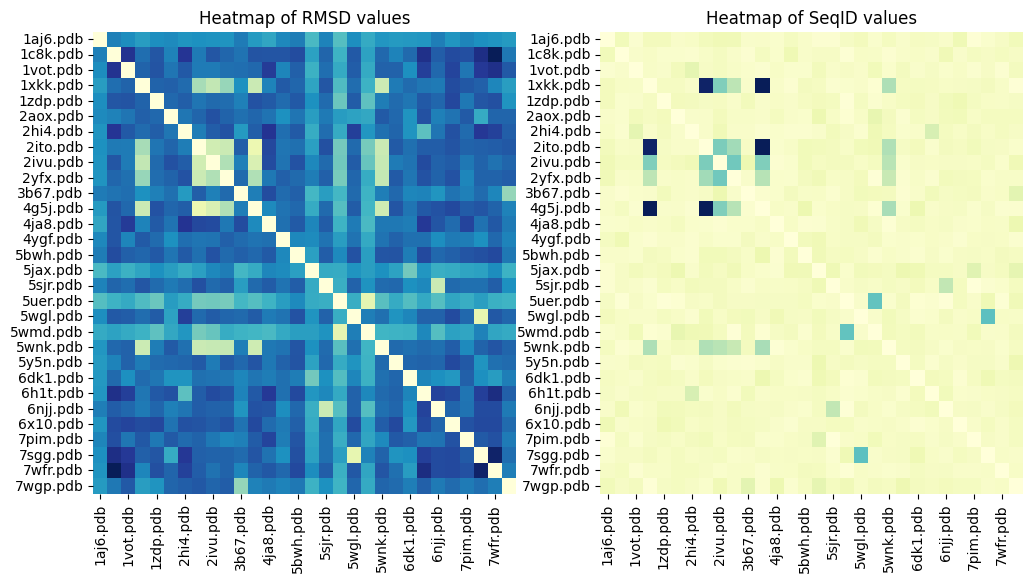

In [8]:
""" Heatmap of RMSD values of proteins in dataset
NOTE: it is needed to install bassh tool TM-align
## apt install tm-align --user
"""
import os
import re
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pdbs = str(new_folder) + "/pdbs"  # directory containing the PDB files
pdb_files = sorted(os.listdir(pdbs))

matrix_rmsd = [[0 for i in range(len(pdb_files))] for j in range(len(pdb_files))]
matrix_seqid = [[0 for i in range(len(pdb_files))] for j in range(len(pdb_files))]

for i in range(len(pdb_files)):
    for j in range(i+1, len(pdb_files)):
        pdb1 = pdb_files[i]
        pdb2 = pdb_files[j]
        # run TMalign command
        cmd = f"TMalign {os.path.join(pdbs, pdb1)} {os.path.join(pdbs, pdb2)} -a"
        output = os.popen(cmd).read()
        # extract RMSD value
        for line in output.split("\n"):
            if "RMSD" in line:
                rmsd_matches = re.findall(r"RMSD=\s+([\d.]+),", line)
                if len(rmsd_matches) > 0:
                    rmsd = float(rmsd_matches[0])
                else:
                    print(f"Error: could not find RMSD value for {pdb1} vs. {pdb2} in files {pdb1} and {pdb2}")
        matrix_rmsd[i][j] = rmsd
        matrix_rmsd[j][i] = rmsd

        # extract SeqID value
        for line in output.split("\n"):
            if "Seq_ID" in line:
                seqid_match = re.search(r"Seq_ID=n_identical/n_aligned=\s+([\d.]+)", line)
                if seqid_match:
                    seqid = float(seqid_match.group(1))
                else:
                    print(f"Error: could not find SeqID value for {pdb1} vs. {pdb2} in files {pdb1} and {pdb2}")
        matrix_seqid[i][j] = seqid
        matrix_seqid[j][i] = seqid

## save matrices
np.save("matrix_rmsd.npy", matrix_rmsd)
np.save("matrix_seqid.npy", matrix_seqid)

print("RMSD and SeqID analysis")
# Create DataFrames from the matrices
heatmap_rmsd = pd.DataFrame(matrix_rmsd, columns=pdb_files, index=pdb_files)
heatmap_seqid = pd.DataFrame(matrix_seqid, columns=pdb_files, index=pdb_files)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Create the RMSD heatmap
sns.heatmap(heatmap_rmsd, ax=ax1, annot=False, cmap="YlGnBu", cbar=False)
ax1.set_title('Heatmap of RMSD values')

# Create the SeqID heatmap
sns.heatmap(heatmap_seqid, ax=ax2, annot=False, cmap="YlGnBu", cbar=False)
ax2.set_title('Heatmap of SeqID values')

# Remove x and y labels
ax1.set_xlabel("")
ax1.set_ylabel("")
ax2.set_xlabel("")
ax2.set_ylabel("")

# Save the figure
plt.savefig(str(new_folder) + "/heatmap_rmsd_seqid.jpg", format='jpg')
# Display the plot
plt


In [ ]:
""" Fourth step |
This part generates 'lig', 'inter', and 'prot' files
from TSV files retrieved from the Binding DB dataset. Those
files are properly formatted to be used at RINDTI model
https://rindti.readthedocs.io/en/master/index.html
"""

In [ ]:
""" Delimit the dataset | creates a new df with only columns that will be useful for the formating
"""
# we use df and not dataset, because df is already filtered
tsvs = df[['Drug', 'Drug_ID', 'PDB_ID', 'pIC50', 'fasta_sequence']] ## PDB ID will be used to match pdb names
# Select and rename columns
tsvs = tsvs.rename(columns={'PDB_ID': 'Target_ID', 'pIC50': 'Y', 'fasta_sequence': 'Target'})
# Display the updated DataFrame
tsvs.to_csv(str(new_folder) + "/all_drugs.tsv", sep="\t", index=False)
tsvs


In [ ]:
""" Delimit the dataset | creates a new df with only columns that will be useful for the formating
"""

# Read the DataFrame from your data source or use the existing DataFrame
df = pd.read_csv(str(new_folder) + '/all_drugs.tsv', sep="\t")

# Remove duplicates and keep the row with the lowest "Y" value
df = df.sort_values('Y')  # Sort the DataFrame by "Y" column in ascending order
df = df.drop_duplicates(subset='Drug_ID', keep='first')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# Display the updated DataFrame
df.to_csv(str(new_folder) + "/all_drugs.tsv", sep="\t", index=False)

df.shape


In [ ]:
""" Delimit the dataset | creates a lig.tsv file
"""
lig = df.loc[:, ['Drug_ID', 'Drug']]
lig.to_csv(str(new_folder) + "/lig.tsv", sep="\t", index=False)


In [ ]:
""" Delimit the dataset | creates a inter.tsv file
"""
inter = df.loc[:, ['Drug_ID', 'Target_ID', 'Y']]
inter.to_csv(str(new_folder) + "/inter.tsv", sep="\t", index=False)


In [ ]:
""" Delimit the dataset | creates a prot.tsv file
"""
prot = df.loc[:, ['Target_ID', 'Target']]
prot.to_csv(str(new_folder) + "/inter.tsv", sep="\t", index=False)

In [ ]:
""" prot information | creates a TXT file that contains pdb ids 
"""
# check for how many targets
pdb_ids = list(df['Target_ID'].drop_duplicates())
len(pdb_ids)
# print(pdb_ids)

# write their information
with open(str(new_folder) + "/pdb_ids.txt", "w") as output:
        output.write(str(pdb_ids))
